參考:  https://medium.com/@vipinra79/image-classification-using-transfer-learning-with-inceptionv3-in-google-colab-d89c34ba438f


In [1]:
import urllib.request
import os
import zipfile
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop
from shutil import copyfile

In [4]:
# Mount Google Dive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
# Prepare data
import zipfile

# Path to the zip file
zip_path = '/content/gdrive/MyDrive/Colab Notebooks/CNN/data.zip'

destination_path = '/content/gdrive/MyDrive/Colab Notebooks/CNN'

# Open zip file
with zipfile.ZipFile(zip_path, 'r') as file:
  file.extractall(destination_path)

print("finish extracted")

finish extracted


In [6]:
train_dir = "/content/gdrive/MyDrive/Colab Notebooks/CNN/train"

train_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=100,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))

val_dir = "/content/gdrive/MyDrive/Colab Notebooks/CNN/test"

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(val_dir,
                                                              batch_size=100,
                                                              class_mode='categorical',
                                                              target_size=(150, 150))

Found 4757 images belonging to 6 classes.
Found 30 images belonging to 6 classes.


In [8]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a final sigmoid layer for classification
num_classes = len(train_generator.class_indices)
x = layers.Dense(num_classes, activation='softmax')(x)

model = Model(pre_trained_model.input, x)

In [50]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['acc'])

# Train the model
history = model.fit(
            train_generator,
            validation_data=validation_generator,
            epochs=30,
            verbose=1)

Epoch 1/30
48/48 [==============================] - 48s 919ms/step - loss: 0.2519 - acc: 0.8995 - val_loss: 0.8222 - val_acc: 0.7333
Epoch 2/30
48/48 [==============================] - 41s 856ms/step - loss: 0.2219 - acc: 0.9071 - val_loss: 0.5003 - val_acc: 0.7333
Epoch 3/30
48/48 [==============================] - 41s 857ms/step - loss: 0.2128 - acc: 0.9100 - val_loss: 0.2780 - val_acc: 0.8667
Epoch 4/30
48/48 [==============================] - 42s 863ms/step - loss: 0.2007 - acc: 0.9144 - val_loss: 0.4391 - val_acc: 0.7333
Epoch 5/30
48/48 [==============================] - 42s 880ms/step - loss: 0.2103 - acc: 0.9065 - val_loss: 0.2845 - val_acc: 0.8333
Epoch 6/30
48/48 [==============================] - 42s 875ms/step - loss: 0.1996 - acc: 0.9157 - val_loss: 0.4213 - val_acc: 0.7333
Epoch 7/30
48/48 [==============================] - 42s 873ms/step - loss: 0.1784 - acc: 0.9250 - val_loss: 1.2685 - val_acc: 0.6333
Epoch 8/30
48/48 [==============================] - 42s 866ms/step - 

In [51]:
model_name = 'bottle_classification_inceptionV3.h5'
model.save(model_name, save_format='h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Text(0.5, 1.0, 'Training accuracy')

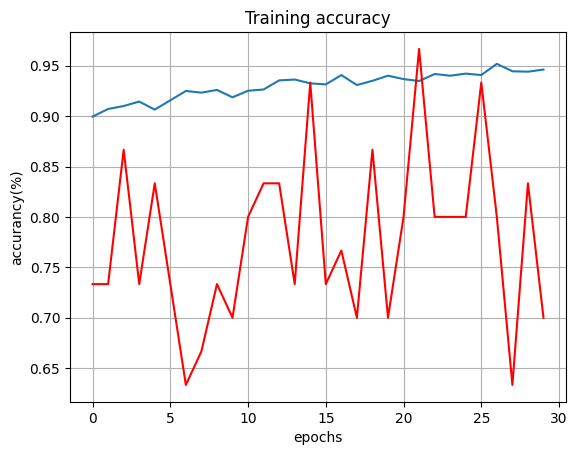

In [52]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.figure()
plt.plot(epochs, acc, label='train acc')
plt.plot(epochs, val_acc, label='val acc', c='red')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('accurancy(%)')

plt.title('Training accuracy')
